# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load and Preprocessing the data 

In [3]:
data = []
labels = []
IMG_SIZE = 100

path = '/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG'

for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        try:
            image = cv2.imread(img_path)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            data.append(image)
            labels.append(folder)
        except:
            continue

data = np.array(data) / 255.0  # Normalize the images
labels = np.array(labels)

# 1. Train the model with 30% test data


In [4]:
sequence_length = 5

# Step 2: Create new sequence-based lists
new_data = []
new_labels = []

# Loop through dataset and group every 'sequence_length' images
for i in range(0, len(data) - sequence_length + 1, sequence_length):
    sequence = data[i:i+sequence_length]
    label_seq = labels[i:i+sequence_length]
    
    # Optional: check if all labels in the sequence are the same
    if all(label == label_seq[0] for label in label_seq):
        new_data.append(sequence)
        new_labels.append(label_seq[0])  # use the common label
    else:
        continue  # skip mixed sequences

# Step 3: Convert to NumPy arrays
X_seq = np.array(new_data)       # shape: (num_sequences, 5, 100, 100, 3)
y_seq = np.array(new_labels)     # shape: (num_sequences,)

# Step 4: Encode labels if they are still in string format
label_encoder = LabelEncoder()
y_seq_encoded = label_encoder.fit_transform(y_seq)

# Step 5: One-hot encode the output labels
y_seq_onehot = to_categorical(y_seq_encoded)

# 1. Step 1: Splitting the Data 
Test data 30% 

In [5]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq_onehot, test_size=0.3, random_state=42)

In [6]:
total_samples = len(X_seq)
test_data_percent = round(len(X_test_seq) / total_samples * 100, 2)
train_data_percent = round(len(X_train_seq) / total_samples * 100, 2)
print(test_data_percent)
print(train_data_percent)

30.02
69.98


# 1. Step 2: Build the CNN+LSTM Model 
Test data 30% 

In [8]:
model = Sequential()

# CNN layers wrapped in TimeDistributed
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(sequence_length, 100, 100, 3)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(TimeDistributed(Flatten()))

# LSTM layer
model.add(LSTM(64))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_seq_onehot.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_5 (TimeDistributed) │ (None, 5, 98, 98, 32)       │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 5, 49, 49, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 5, 47, 47, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 5, 23, 23, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 5, 33856)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │       8,683,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,707,913 (33.22 MB)

 Trainable params: 8,707,913 (33.22 MB)

 Non-trainable params: 0 (0.00 B)

# 1. Step 3: Training the model
Test data 30% 

In [9]:
history = model.fit(
    X_train_seq, y_train_seq, 
    validation_data=(X_test_seq, y_test_seq),
    epochs=10, 
    batch_size=32
)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.2211 - loss: 2.1343 - val_accuracy: 0.3980 - val_loss: 1.7760
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.3529 - loss: 1.7411 - val_accuracy: 0.4618 - val_loss: 1.4640
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.4972 - loss: 1.3953 - val_accuracy: 0.6841 - val_loss: 0.9656
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.6759 - loss: 0.9720 - val_accuracy: 0.7649 - val_loss: 0.6757
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.8104 - loss: 0.6112 - val_accuracy: 0.8074 - val_loss: 0.5295
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.8955 - loss: 0.3646 - val_accuracy: 0.8810 - val_loss: 0.3633
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.9333 - loss: 0.2385 - val_accuracy: 0.9093 - val_loss: 0.2510
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.9608 - loss: 0.1654 - val_accuracy: 0.9122 - v

# 1. Step 4: Showing the Test accuracy 
with 30% test data 

In [10]:
loss, acc = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Accuracy: {acc * 100:.2f}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 740ms/step - accuracy: 0.9433 - loss: 0.1906
Test Accuracy: 93.20%


# 2. Train the model with 35% test data
Put the data into another variable 

In [12]:
data_1 = data # Normalize the images
labels_1 = labels

In [13]:
#step 1
sequence_length_1 = 5

# Step 2: Create new sequence-based lists
new_data_1 = []
new_labels_1 = []

# Loop through dataset and group every 'sequence_length' images
for j in range(0, len(data_1) - sequence_length_1 + 1, sequence_length_1):
    sequence1 = data_1[j:j+sequence_length_1]
    label_seq1 = labels_1[j:j+sequence_length_1]
    
    # Optional: check if all labels in the sequence are the same
    if all(label1 == label_seq1[0] for label1 in label_seq1):
        new_data_1.append(sequence1)
        new_labels_1.append(label_seq1[0])  # use the common label
    else:
        continue  # skip mixed sequences

# Step 3: Convert to NumPy arrays
X_seq1 = np.array(new_data_1)       # shape: (num_sequences, 5, 100, 100, 3)
y_seq1 = np.array(new_labels_1)     # shape: (num_sequences,)

# Step 4: Encode labels if they are still in string format
label_encoder1 = LabelEncoder()
y_seq_encoded1 = label_encoder1.fit_transform(y_seq1)

# Step 5: One-hot encode the output labels
y_seq_onehot1 = to_categorical(y_seq_encoded1)

# 2. Step 1: Splitting the Data 
Test data 35% 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq1, y_seq_onehot1, test_size=0.35, random_state=42)

In [15]:
total_samples1 = len(X_seq1)
test_data_percent1 = round(len(X_test) / total_samples1 * 100, 2)
train_data_percent1 = round(len(X_train) / total_samples1 * 100, 2)
print(test_data_percent1)
print(train_data_percent1)

35.03
64.97


# 2. Step 2: Build the CNN+LSTM Model
Test data 35%

In [17]:
model1 = Sequential()

# CNN layers wrapped in TimeDistributed
model1.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(sequence_length_1, 100, 100, 3)))
model1.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model1.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model1.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model1.add(TimeDistributed(Flatten()))

# LSTM layer
model1.add(LSTM(64))

# Dense layers
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(y_seq_onehot1.shape[1], activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_15                  │ (None, 5, 98, 98, 32)       │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 5, 49, 49, 32)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 5, 47, 47, 64)       │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_18                  │ (None, 5, 23, 23, 64)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_19                  │ (None, 5, 33856)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │       8,683,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,707,913 (33.22 MB)

 Trainable params: 8,707,913 (33.22 MB)

 Non-trainable params: 0 (0.00 B)

# 2. Step 3: Training the model
Test data 35%

In [18]:
history1 = model1.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=10, 
    batch_size=32
)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.1698 - loss: 2.2127 - val_accuracy: 0.3447 - val_loss: 1.9311
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.3056 - loss: 1.9111 - val_accuracy: 0.4223 - val_loss: 1.6853
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.4215 - loss: 1.6466 - val_accuracy: 0.5971 - val_loss: 1.2992
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.5382 - loss: 1.2779 - val_accuracy: 0.7403 - val_loss: 0.8802
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.7130 - loss: 0.8456 - val_accuracy: 0.7888 - val_loss: 0.6585
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.8325 - loss: 0.5759 - val_accuracy: 0.8811 - val_loss: 0.4052
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.9140 - loss: 0.3339 - val_accuracy: 0.8799 - val_loss: 0.3479
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9512 - loss: 0.2270 - val_accuracy: 0.9150 - v

# 2. Step 4: Showing the Test accuracy
with 35% test data

In [19]:
loss1, acc1 = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc1 * 100:.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 896ms/step - accuracy: 0.9084 - loss: 0.2779
Test Accuracy: 91.63%


# 3. Train the model with 20% test data
Put the data into another variable

In [20]:
data_2 = data # Normalize the images
labels_2 = labels

In [21]:
sequence_length_2 = 5

# Step 2: Create new sequence-based lists
new_data_2 = []
new_labels_2 = []

# Loop through dataset and group every 'sequence_length' images
for k in range(0, len(data_2) - sequence_length_2 + 1, sequence_length_2):
    sequence2 = data_2[k:k+sequence_length_2]
    label_seq2 = labels_2[k:k+sequence_length_2]
    
    # Optional: check if all labels in the sequence are the same
    if all(label2 == label_seq2[0] for label2 in label_seq2):
        new_data_2.append(sequence2)
        new_labels_2.append(label_seq2[0])  # use the common label
    else:
        continue  # skip mixed sequences

# Step 3: Convert to NumPy arrays
X_seq2 = np.array(new_data_2)       # shape: (num_sequences, 5, 100, 100, 3)
y_seq2 = np.array(new_labels_2)     # shape: (num_sequences,)

# Step 4: Encode labels if they are still in string format
label_encoder2 = LabelEncoder()
y_seq_encoded2 = label_encoder2.fit_transform(y_seq2)

# Step 5: One-hot encode the output labels
y_seq_onehot2 = to_categorical(y_seq_encoded2)

# 3. Step 1: Splitting the Data
Test data 20%

In [23]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_seq2, y_seq_onehot2, test_size=0.2, random_state=42)

# 3. Step 2: Build the CNN+LSTM Model
Test data 20%

In [25]:
model2 = Sequential()

# CNN layers wrapped in TimeDistributed
model2.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(sequence_length_2, 100, 100, 3)))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model2.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model2.add(TimeDistributed(Flatten()))

# LSTM layer
model2.add(LSTM(64))

# Dense layers
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(y_seq_onehot2.shape[1], activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_25                  │ (None, 5, 98, 98, 32)       │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_26                  │ (None, 5, 49, 49, 32)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_27                  │ (None, 5, 47, 47, 64)       │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_28                  │ (None, 5, 23, 23, 64)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, 5, 33856)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │       8,683,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,707,913 (33.22 MB)

 Trainable params: 8,707,913 (33.22 MB)

 Non-trainable params: 0 (0.00 B)

# 3. Step 3: Training the model
Test data 20%

In [26]:
history2 = model2.fit(
    X_train2, y_train2, 
    validation_data=(X_test2, y_test2),
    epochs=10, 
    batch_size=32
)

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.1640 - loss: 2.1785 - val_accuracy: 0.4076 - val_loss: 1.8342
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.4065 - loss: 1.7025 - val_accuracy: 0.6518 - val_loss: 1.1035
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.6432 - loss: 1.0643 - val_accuracy: 0.7325 - val_loss: 0.7683
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.7272 - loss: 0.7421 - val_accuracy: 0.8004 - val_loss: 0.6068
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.8159 - loss: 0.5574 - val_accuracy: 0.8832 - val_loss: 0.3295
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.9290 - loss: 0.2816 - val_accuracy: 0.8323 - val_loss: 0.4482
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9273 - loss: 0.2469 - val_accuracy: 0.8896 - val_loss: 0.2810
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.9799 - loss: 0.1278 - val_accuracy: 0.8854 - v

# 3. Step 4: Showing the Test accuracy
with 20% test data

In [27]:
loss2, acc2 = model2.evaluate(X_test2, y_test2)
print(f"Test Accuracy: {acc2 * 100:.2f}%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 469ms/step - accuracy: 0.8901 - loss: 0.2795
Test Accuracy: 89.17%


# Save the model

In [28]:
model2.save("rice_leaf_cnn_lstm_model.h5")

In [29]:
labels_3 = labels

# Define your label binarizer classes

In [32]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
labels_3 = lb.fit_transform(labels_3)

In [34]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

# Save label binarizer (after fitting it)
with open('/kaggle/working/label_binarizer.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Load model and label binarizer
model3 = load_model('/kaggle/working/rice_leaf_cnn_lstm_model.h5')  # Use your actual model filename
with open('/kaggle/working/label_binarizer.pkl', 'rb') as f:
    lb = pickle.load(f)

# Prediction function for a each images

In [45]:
def predict_image_sequence(image_paths):
    import matplotlib.pyplot as plt
    import cv2
    import numpy as np

    images = []

    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (100, 100))
        img = img.astype('float32') / 255.0
        images.append(img)

    if len(images) != 5:
        raise ValueError("Exactly 5 images are required for prediction with CNN+LSTM model.")

    sequence = np.array(images).reshape(1, 5, 100, 100, 3)

    # Predict
    prediction = model3.predict(sequence)[0]
    class_index = np.argmax(prediction)
    confidence = prediction[class_index] * 100

    # ✅ Get disease name using label encoder
    predicted_class = label_encoder.inverse_transform([class_index])[0]

    # Plot image and result
    plt.figure(figsize=(3, 3))
    plt.imshow(images[0])
    plt.axis('off')
    plt.title(f"{predicted_class}\nConfidence: {confidence:.2f}%", fontsize=12)
    plt.show()

    print(f"✅ Predicted Class: {predicted_class}")
    print(f"✅ Confidence: {confidence:.2f}%")

# Run prediction on your sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


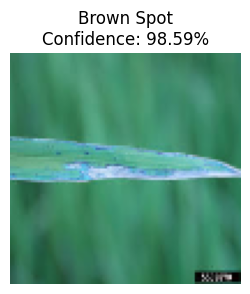

✅ Predicted Class: Brown Spot
✅ Confidence: 98.59%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


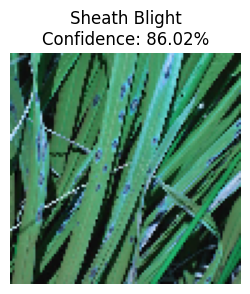

✅ Predicted Class: Sheath Blight
✅ Confidence: 86.02%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


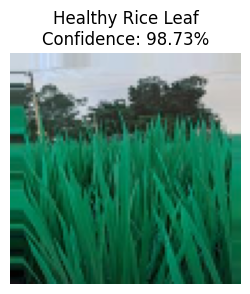

✅ Predicted Class: Healthy Rice Leaf
✅ Confidence: 98.73%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


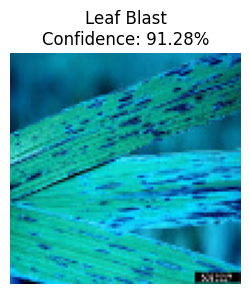

✅ Predicted Class: Leaf Blast
✅ Confidence: 91.28%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


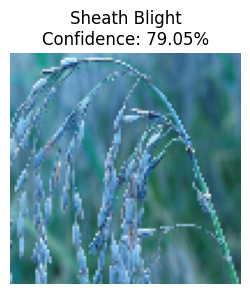

✅ Predicted Class: Sheath Blight
✅ Confidence: 79.05%


In [49]:
# /kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG

predict_image_sequence(['/kaggle/input/sample-rice-leaf4/images.jpg']*5)
predict_image_sequence(['/kaggle/input/sample-rice-leaf4/unnamed1.jpg']*5)
predict_image_sequence(['/kaggle/input/sample-rice-leaf4/healleaf.jpg']*5)
predict_image_sequence(['/kaggle/input/sample-rice-leaf4/images (1).jpg']*5)
predict_image_sequence(['/kaggle/input/sample-rice-leaf4/unnamed2.jpg']*5)